# How-to Guide: Capturing JSON from stdout and Reusing It in Another CWL Tool

This guide demonstrates how to capture a JSON response from the stdout of one CWL tool and reuse it as input for another tool.

We'll focus on two key sections:

1. Capturing JSON output:

In [1]:
cwl_file="../cwl/03-json-stdout/capture-json-stdout.cwl"

In [2]:
cat  $cwl_file | yq e .'$graph[1]' - | yq '.. | select(has("stdout")) | {"stdout": .stdout}'

stdout: message


In [3]:
cat  $cwl_file | yq e .'$graph[1]' - | yq '.. | select(has("outputs")) | {"outputs": .outputs}'


outputs:
  asset:
    type: Any
    outputBinding:
      glob: message
      loadContents: true
      outputEval: ${ return JSON.parse(self[0].contents).assets; }


2. Reusing captured JSON in another tool:

In [4]:
cat $cwl_file | yq e .'$graph[2]' - | yq '.. | select(has("arguments")) | {"arguments": (.arguments | .[-2:])}'


arguments:
  - valueFrom: "${\n    let redKey = Object.keys(inputs.asset).find(key => \n        inputs.asset[key]['eo:bands'] && \n        inputs.asset[key]['eo:bands'].length === 1 &&\n        inputs.asset[key]['eo:bands'].some(band => band.common_name === inputs.common_band_name)\n    );\n    return inputs.asset[redKey].href;\n}\n"
  - valueFrom: |
      ${
          return inputs.common_band_name + ".png";
      }



## Objective

- Tool 1 (`stac`): Fetch a STAC item in JSON format and extract its `assets`.
- Tool 2 (`rio`): Process the extracted asset to generate a PNG image based on the specified band.

## Steps

1. Capturing JSON from stdout

In the `stac` tool:

Relevant Block

In [5]:
cat  $cwl_file | yq e .'$graph[1]' - | yq '.. | select(has("stdout")) | {"stdout": .stdout}'

stdout: message


In [6]:
cat  $cwl_file | yq e .'$graph[1]' - | yq '.. | select(has("outputs")) | {"outputs": .outputs}'

outputs:
  asset:
    type: Any
    outputBinding:
      glob: message
      loadContents: true
      outputEval: ${ return JSON.parse(self[0].contents).assets; }


* `stdout: message`: Redirects the tool's `stdout` to a file named `message`.
* `glob: message`: Locates the `message` file.
* `loadContents: true`: Reads the content of the file into memory.
* `outputEval`: Parses the JSON content to extract the `assets` field using JavaScript (`JSON.parse`).

How It Works

* The `stac` tool fetches a STAC item as JSON using `curl`.
* The output (`stdout`) is saved to `message`.
* The `outputs` block processes this JSON and makes the `assets` field available for downstream steps.

2. Reusing Captured JSON in Another Tool

In the `rio` tool:

Relevant Block

In [7]:
cat $cwl_file | yq e .'$graph[2]' - | yq '.. | select(has("arguments")) | {"arguments": (.arguments | .[-2:])}'


arguments:
  - valueFrom: "${\n    let redKey = Object.keys(inputs.asset).find(key => \n        inputs.asset[key]['eo:bands'] && \n        inputs.asset[key]['eo:bands'].length === 1 &&\n        inputs.asset[key]['eo:bands'].some(band => band.common_name === inputs.common_band_name)\n    );\n    return inputs.asset[redKey].href;\n}\n"
  - valueFrom: |
      ${
          return inputs.common_band_name + ".png";
      }



* First `valueFrom`: Selects the asset whose `eo:bands` array contains a band with a `common_name` matching `inputs.common_band_name` and returns its `href`.
* Second `valueFrom`: Generates the output filename for the PNG (`red.png` for the `red` band).

How It Works

* The `rio` tool processes the asset URL (href) extracted in the first step.`
* It generates a PNG file using the `common-band-name` and saves it as `<common-band-name>.png.

3. Complete CWL Example

Here’s the full `capture-json-stdout.cwl` file:

In [8]:
yq e . $cwl_file 

cwlVersion: v1.2
$graph:
  - class: Workflow
    id: main
    requirements:
      InlineJavascriptRequirement: {}
      NetworkAccess:
        networkAccess: true
    inputs:
      stac-item:
        type: string
      common-band-name:
        type: string
    outputs:
      preview:
        outputSource: step_translate/preview
        type: File
      json_output:
        outputSource: step_stac/asset
        type: Any
    steps:
      step_stac:
        in:
          stac_item: stac-item
        out:
          - asset
        run: "#stac"
      step_translate:
        in:
          asset:
            source: step_stac/asset
          common_band_name: common-band-name
        out:
          - preview
        run: "#rio"
  - class: CommandLineTool
    id: stac
    requirements:
      DockerRequirement:
        dockerPull: docker.io/curlimages/curl:latest
    baseCommand: curl
    arguments:
      - -s
      - $( inputs.stac_item )
    inputs:
      stac_item:
        type: string
   

It's graphical representation:

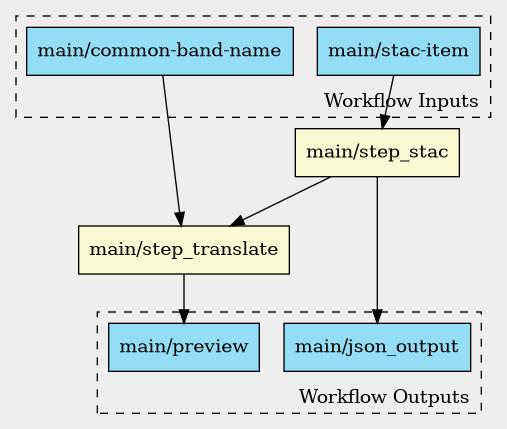

In [9]:
cwltool --print-dot $cwl_file 2> /dev/null | dot -Tpng | display

4. Run the Example

Command to execute the workflow:

```bash
cwltool capture-json-stdout.cwl \
  --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A \
  --common-band-name red
```

5. Execute the CWL Tool

Run the command in your terminal:

```bash
cwltool capture-json-stdout.cwl \
  --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A \
  --common-band-name red
```

In [10]:
cwltool $cwl_file \
    --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A \
    --common-band-name red > output.json

INFO /home/fbrito/.local/bin/cwltool 3.1.20240508115724
INFO Resolved '../cwl/03-json-stdout/capture-json-stdout.cwl' to 'file:///data/work/github/eoepca-plus/how-to/cwl/03-json-stdout/capture-json-stdout.cwl'
INFO [workflow ] start
INFO [workflow ] starting step step_stac
INFO [step step_stac] start
INFO [job step_stac] /tmp/abfqbhmn$ docker \
    run \
    -i \
    --mount=type=bind,source=/tmp/abfqbhmn,target=/TKfFHP \
    --mount=type=bind,source=/tmp/u3mvxz4y,target=/tmp \
    --workdir=/TKfFHP \
    --read-only=true \
    --log-driver=none \
    --user=1000:1000 \
    --rm \
    --cidfile=/tmp/llgnufkw/20241229135031-110630.cid \
    --env=TMPDIR=/tmp \
    --env=HOME=/TKfFHP \
    docker.io/curlimages/curl:latest \
    curl \
    -s \
    https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A > /tmp/abfqbhmn/message
INFO [job step_stac] Max memory used: 0MiB
INFO [job step_stac] completed success
INFO [step step_stac] completed 


## Expected Output

* Intermediate Output (`json_output`): Extracted assets from the STAC item JSON.
* Final Output (`preview`): PNG file for the specified band (e.g., `red.png`).

In [15]:
cat output.json | yq e '.json_output' -o=json -

{
  "thumbnail": {
    "title": "Thumbnail",
    "type": "image/png",
    "roles": [
      "thumbnail"
    ],
    "href": "https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/53/H/PA/2021/7/23/0/preview.jpg"
  },
  "overview": {
    "title": "True color image",
    "type": "image/tiff; application=geotiff; profile=cloud-optimized",
    "roles": [
      "overview"
    ],
    "gsd": 10,
    "eo:bands": [
      {
        "name": "B04",
        "common_name": "red",
        "center_wavelength": 0.6645,
        "full_width_half_max": 0.038
      },
      {
        "name": "B03",
        "common_name": "green",
        "center_wavelength": 0.56,
        "full_width_half_max": 0.045
      },
      {
        "name": "B02",
        "common_name": "blue",
        "center_wavelength": 0.4966,
        "full_width_half_max": 0.098
      }
    ],
    "href": "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/H/PA/2021/7/S2B_53HPA_20210723_0_L2A/L2A_PVI.tif",
    "proj:shape": 

In [16]:
cat output.json | yq e '.preview' -o=json -

{
  "location": "file:///data/work/github/eoepca-plus/how-to/docs/red.png",
  "basename": "red.png",
  "class": "File",
  "checksum": "sha1$3b0ab5ca89bc640e276ac48c6d37a900a4493708",
  "size": 103995863,
  "path": "/data/work/github/eoepca-plus/how-to/docs/red.png"
}


## Key Takeaways

* Capturing JSON:

  * Use `stdout` to redirect the JSON output to a file.
  * Parse and extract specific fields using `outputEval`.

* Reusing JSON:

  * Use `valueFrom` in arguments to select fields dynamically from the JSON input.
  * Process the selected field (e.g., generate a file based on its href).

By focusing on `stdout` and `outputBinding`, this guide highlights how CWL facilitates JSON data flow between tools.